In [43]:
import matplotlib.pyplot as plt
from pathlib import Path
import json
import torch
from sklearn.manifold import TSNE
import numpy as np

from data import get_training_and_validation_data
from autoencoder import Autoencoder

model_id = 'C3WMCCMAFT'
model_config = json.load(open(Path('models') / model_id / 'config.json', 'r'))
dataset_id = model_config['dataset_id']

X_train, y_train, X_val, y_val = get_training_and_validation_data(Path('processed_data'), dataset_id)
X_mean, X_std = X_train.mean(), X_train.std()
X_train -= X_mean
X_train /= X_std
X_val -= X_mean
X_val /= X_std
X_train = X_train[:, :, 0]
X_train_tensor = torch.from_numpy(X_train).to(torch.float32)
X_val = X_val[:, :, 0]
X_val_tensor = torch.from_numpy(X_val).to(torch.float32)

autoencoder = Autoencoder(input_dim=X_train.shape[1], latent_dim=model_config['latent_dim'],
                          hidden_dims=[model_config['l1'], model_config['l2']],
                          activation=model_config['activation'],
                          latent_activation=model_config['latent_activation'],
                          negative_slope=model_config['negative_slope'])
autoencoder.load_state_dict(torch.load(Path('models') / model_id / 'ae.pth'))
autoencoder.eval()

X_train_enc = autoencoder.encoder(X_train_tensor)
X_train_rec = autoencoder.decoder(X_train_enc).detach().numpy()
X_train_enc = X_train_enc.detach().numpy()
X_train_tsne = TSNE().fit_transform(X_train_enc)
X_val_enc = autoencoder.encoder(X_val_tensor)
X_val_rec = autoencoder.decoder(X_val_enc).detach().numpy()
X_val_enc = X_val_enc.detach().numpy()
X_val_tsne = TSNE().fit_transform(X_val_enc)

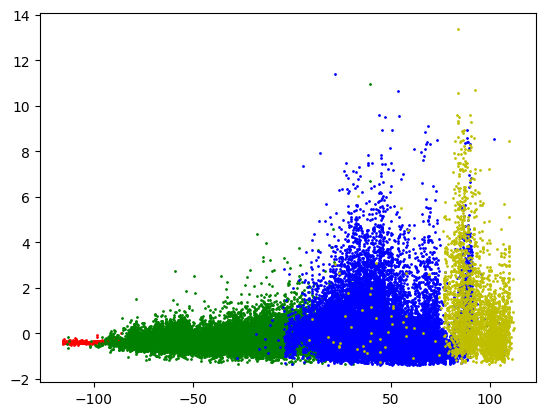

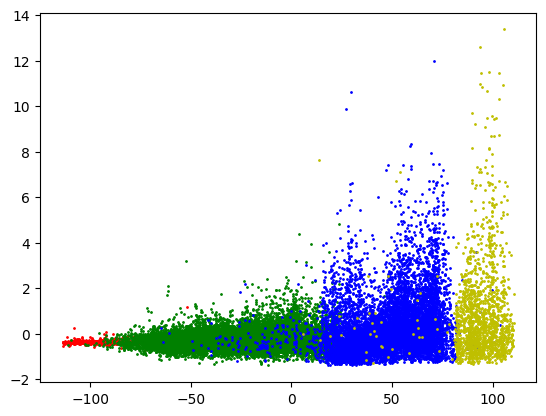

In [44]:
colors = ['r', 'g', 'b', 'y']

for label in np.unique(y_train):
    plt.scatter(X_train_tsne[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[label], s=1)

plt.show()

for label in np.unique(y_val):
    plt.scatter(X_val_tsne[y_val == label, 0], X_val[y_val == label, 1], 
                c=colors[label], s=1)

plt.show()

In [45]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from metrics import acc

In [46]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train_enc)
y_pred = kmeans.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

/Users/timodewaele/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2118
           1       0.85      0.99      0.91     15035
           2       0.97      0.71      0.82      9923
           3       0.28      0.58      0.38      1555

    accuracy                           0.79     28631
   macro avg       0.52      0.57      0.53     28631
weighted avg       0.80      0.79      0.78     28631



In [47]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_train_enc)
y_pred = gmm.predict(X_val_enc)
_, label_mapping = acc(y_val, y_pred, return_mapping=True)
y_pred = np.vectorize(label_mapping.get)(y_pred)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83      2118
           1       0.94      0.84      0.89     15035
           2       0.66      0.47      0.55      9923
           3       0.23      1.00      0.38      1555

    accuracy                           0.71     28631
   macro avg       0.71      0.76      0.66     28631
weighted avg       0.81      0.71      0.74     28631

